In [10]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

REPO_ROOT = Path.cwd().parent.parent
BACKEND_DIR = REPO_ROOT / "backend"
sys.path.insert(0, str(BACKEND_DIR))

from analytics.forecasting.prophet import ProphetForecaster



Fetching data for NVDA and ^VIX...


[*********************100%***********************]  1 of 1 completed


Loaded 262 rows. Latest date: 2026-02-23 00:00:00


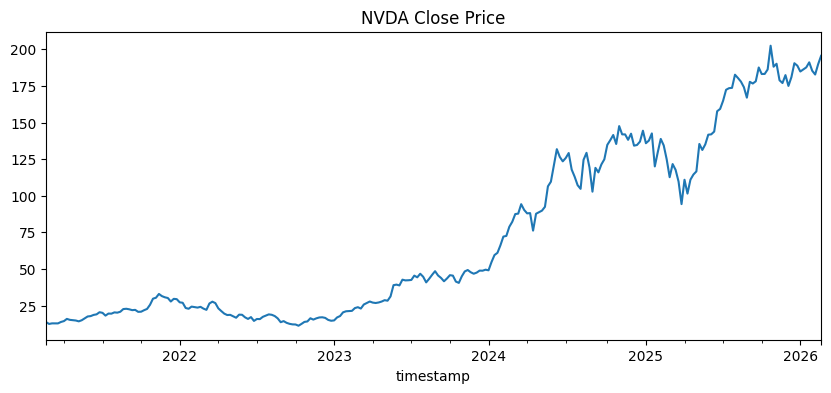

In [11]:
SYMBOL = "NVDA"
VIX_SYMBOL = "^VIX"
INTERVAL = "1wk"
PERIOD = "5y"

print(f"Fetching data for {SYMBOL} and {VIX_SYMBOL}...")

df = yf.download(tickers=SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False)
df = df.reset_index().rename(columns={"Date": "timestamp", "Close": "close"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

prices = df.set_index("timestamp")["close"].astype(float).dropna()

# Load VIX (same period/interval) and align to price dates
vix_raw = yf.download(tickers=VIX_SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False, progress=False)
vix_raw = vix_raw.reset_index().rename(columns={"Date": "timestamp", "Close": "vix"})
vix_raw["timestamp"] = pd.to_datetime(vix_raw["timestamp"])
vix = vix_raw.set_index("timestamp")["vix"].astype(float).reindex(prices.index).ffill().bfill()

print(f"Loaded {len(prices)} rows. Latest date: {prices.index.max()}")
prices.head()

prices.plot(title=f"{SYMBOL} Close Price", figsize=(10, 4))
plt.show()



In [12]:
TEST_SIZE = 30          # Final comparison window (same for EMA, Prophet, Prophet+XGB)
PROPHET_WINDOW = 80    # Run Prophet backtest this many steps so we have enough history for XGB training
MIN_TRAIN = 10
RESIDUAL_LAGS = 3      # Lags of (actual - prophet) for XGB features
PRICE_LAGS = 3         # Price lags for XGB features

def backtest_one_step(prices_full: pd.Series, test_size: int, model_factory, min_train: int):
    preds = []
    split_idx = len(prices_full) - test_size
    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        actual = float(prices_full.iloc[i])
        ts = prices_full.index[i]
        if len(train) < min_train:
            continue
        model = model_factory()
        model.fit(train)
        fc = model.forecast(periods=1)
        yhat = float(fc["point_forecast"][0])
        preds.append({"timestamp": ts, "y_true": actual, "y_pred": yhat})
    return pd.DataFrame(preds)

# Prophet backtest over PROPHET_WINDOW steps (needed for XGB training data)
pred_prophet_full = backtest_one_step(
    prices, PROPHET_WINDOW,
    model_factory=lambda: ProphetForecaster(confidence_level=0.95),
    min_train=MIN_TRAIN,
)
pred_prophet = pred_prophet_full.tail(TEST_SIZE).reset_index(drop=True)  # last TEST_SIZE for comparison
print("Prophet backtest done. Rows (full):", len(pred_prophet_full), "| Last", TEST_SIZE, "for comparison.")

# EMA baseline (same walk-forward: 1-step ahead on last TEST_SIZE points)
def ema_series(close: np.ndarray, span: int) -> np.ndarray:
    alpha = 2.0 / (span + 1)
    ema = np.empty_like(close, dtype=float)
    ema[0] = close[0]
    for i in range(1, len(close)):
        ema[i] = alpha * close[i] + (1 - alpha) * ema[i - 1]
    return ema

EMA_SPAN = 10
pred_ema = []
split_idx = len(prices) - TEST_SIZE
for i in range(split_idx, len(prices)):
    current_close = prices.iloc[:i].values
    ema = ema_series(current_close, EMA_SPAN)
    yhat = float(ema[-1])
    pred_ema.append({"timestamp": prices.index[i], "y_true": float(prices.iloc[i]), "y_pred": yhat})
pred_ema = pd.DataFrame(pred_ema)
print("EMA baseline done. Rows:", len(pred_ema))
pred_prophet.head()

17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:21 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1] done processing
17:07:21 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1] done processing
17:07:22 - cmdstanpy - INFO - Chain [1] start processing
17:07:22 - cmdstanpy - INFO - Chain [1]

Prophet backtest done. Rows (full): 80 | Last 30 for comparison.
EMA baseline done. Rows: 30


,timestamp,y_true,y_pred
0,2025-08-04,182.679520,152.4321
1,2025-08-11,180.429779,157.1486
2,2025-08-18,177.970062,161.1032
3,2025-08-25,174.160477,160.5081
4,2025-09-01,167.001297,159.8654


In [13]:
# Build feature matrix: residuals (actual - prophet) + price lags + VIX (lagged) for XGB
# Align pred_prophet_full with prices and vix
model_df = pred_prophet_full.copy()
model_df["residual"] = model_df["y_true"] - model_df["y_pred"]
# Merge in price and vix at each timestamp (use previous week's price/vix to avoid leakage)
price_series = prices.reindex(model_df["timestamp"])
vix_series = vix.reindex(model_df["timestamp"])
model_df["close"] = price_series.values
model_df["vix"] = vix_series.values
for lag in range(1, RESIDUAL_LAGS + 1):
    model_df[f"residual_lag_{lag}"] = model_df["residual"].shift(lag)
for lag in range(1, PRICE_LAGS + 1):
    model_df[f"price_lag_{lag}"] = model_df["close"].shift(lag)
model_df["vix_lag_1"] = model_df["vix"].shift(1)
model_df = model_df.dropna()

feature_cols = [c for c in model_df.columns if c.startswith("residual_lag_") or c.startswith("price_lag_")] + ["vix_lag_1"]
target_col = "residual"

XGB_PARAMS = dict(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

def walk_forward_prophet_xgb(model_df, feature_cols, test_size):
    """Walk-forward: train XGB on residual (y_true - prophet), predict correction; final = prophet + correction."""
    n = len(model_df)
    split_idx = n - test_size
    preds = []
    for i in range(split_idx, n):
        train = model_df.iloc[:i]
        test_row = model_df.iloc[i : i + 1]
        y_train_residual = train["y_true"] - train["y_pred"]
        model = XGBRegressor(**XGB_PARAMS)
        model.fit(train[feature_cols], y_train_residual)
        prophet_forecast = float(test_row["y_pred"].iloc[0])
        predicted_residual = model.predict(test_row[feature_cols])[0]
        y_final = prophet_forecast + predicted_residual
        preds.append({
            "timestamp": test_row["timestamp"].iloc[0],
            "y_true": float(test_row["y_true"].iloc[0]),
            "y_pred": y_final,
        })
    return pd.DataFrame(preds)

pred_ensemble = walk_forward_prophet_xgb(model_df, feature_cols, TEST_SIZE)
print("Prophet + XGBoost ensemble done. Rows:", len(pred_ensemble))
pred_ensemble.head()

Prophet + XGBoost ensemble done. Rows: 30


,timestamp,y_true,y_pred
0,2025-08-04,182.679520,176.337997
1,2025-08-11,180.429779,180.113266
2,2025-08-18,177.970062,184.552979
3,2025-08-25,174.160477,180.539261
4,2025-09-01,167.001297,178.544495


In [14]:
feature_cols

['residual_lag_1',
 'residual_lag_2',
 'residual_lag_3',
 'price_lag_1',
 'price_lag_2',
 'price_lag_3',
 'vix_lag_1']


--- Comparison (same test window, walk-forward 1-step) ---
        EMA baseline  Prophet  Prophet + XGBoost
MAE           7.4503   9.7010             5.6357
RMSE          9.5258  12.4416             7.0197
MAPE_%        4.0321   5.2989             3.0726


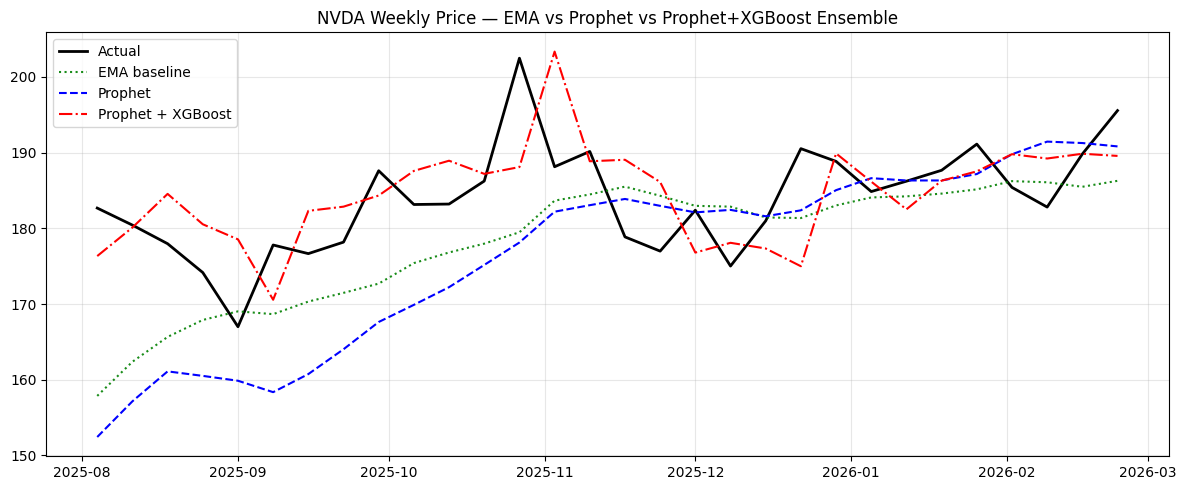

In [15]:
from math import sqrt

def get_metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat) ** 2))
    mape = np.mean(np.abs((y - yhat) / np.maximum(y, 1e-9))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

metrics_ema = get_metrics(pred_ema)
metrics_prophet = get_metrics(pred_prophet)
metrics_ensemble = get_metrics(pred_ensemble)

print("\n--- Comparison (same test window, walk-forward 1-step) ---")
print(pd.DataFrame({
    "EMA baseline": metrics_ema,
    "Prophet": metrics_prophet,
    "Prophet + XGBoost": metrics_ensemble,
}).round(4))

plt.figure(figsize=(12, 5))
plt.plot(pred_ema["timestamp"], pred_ema["y_true"], label="Actual", color="black", linewidth=2)
plt.plot(pred_ema["timestamp"], pred_ema["y_pred"], label="EMA baseline", color="green", linestyle=":", alpha=0.9)
plt.plot(pred_prophet["timestamp"], pred_prophet["y_pred"], label="Prophet", color="blue", linestyle="--")
plt.plot(pred_ensemble["timestamp"], pred_ensemble["y_pred"], label="Prophet + XGBoost", color="red", linestyle="-.")
plt.title(f"{SYMBOL} Weekly Price — EMA vs Prophet vs Prophet+XGBoost Ensemble")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
# OUTDIR.mkdir(parents=True, exist_ok=True)

# path = OUTDIR / "pred_prophet_weekly_price.parquet"
# pred_prophet.to_parquet(path, index=False)

# print("Saved:", path)
# print("Rows:", len(pred_prophet))

In [17]:
# Ensure OUTDIR matches previous artifact location/model.notebooks.artifacts
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

# Define parquet save paths
path_prophet = OUTDIR / "pred_prophet_weekly_price.parquet"
path_ensemble = OUTDIR / "pred_ensemble_weekly_price.parquet"

# Write DataFrames to parquet files
pred_prophet.to_parquet(path_prophet, index=False)
pred_ensemble.to_parquet(path_ensemble, index=False)

print(f"Prophet predictions saved to: {path_prophet} ({len(pred_prophet)} rows)")
print(f"Prophet+XGBoost ensemble predictions saved to: {path_ensemble} ({len(pred_ensemble)} rows)")

Prophet predictions saved to: c:\capstone_project_unfc\model\notebooks\artifacts\pred_prophet_weekly_price.parquet (30 rows)
Prophet+XGBoost ensemble predictions saved to: c:\capstone_project_unfc\model\notebooks\artifacts\pred_ensemble_weekly_price.parquet (30 rows)
